# Causal discovery with `TIGRAMITE`

TIGRAMITE is a time series analysis python module. It allows to reconstruct graphical models (conditional independence graphs) from discrete or continuously-valued time series based on the PCMCI framework and create high-quality plots of the results.

PCMCI is described here:
J. Runge, P. Nowack, M. Kretschmer, S. Flaxman, D. Sejdinovic, 
Detecting and quantifying causal associations in large nonlinear time series datasets. Sci. Adv. 5, eaau4996 (2019) 
https://advances.sciencemag.org/content/5/11/eaau4996

For further versions of PCMCI (e.g., PCMCI+, LPCMCI, etc.), see the corresponding tutorials.

This tutorial explains the missing values and masking and gives walk-through examples. See the following paper for theoretical background:
Runge, Jakob. 2018. “Causal Network Reconstruction from Time Series: From Theoretical Assumptions to Practical Estimation.” Chaos: An Interdisciplinary Journal of Nonlinear Science 28 (7): 075310.

Last, the following Nature Communications Perspective paper provides an overview of causal inference methods in general, identifies promising applications, and discusses methodological challenges (exemplified in Earth system sciences): 
https://www.nature.com/articles/s41467-019-10105-3

In [1]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
from tigramite.models import LinearMediation, Prediction

/home/jakobrunge/anaconda3/envs/py39/lib/python3.9/site-packages/tigramite-5.0.1.18-py3.9.egg/tigramite/plotting.py:26: UserWarning: [Errno 2] No such file or directory: '/home/jakobrunge/anaconda3/envs/py39/lib/python3.9/site-packages/tigramite-5.0.1.18-py3.9.egg/tigramite/../versions.py'
  warnings.warn(str(e))
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/home/jakobrunge/anaconda3/envs/py39/lib/python3.9/site-packages/tigramite-5.0.1.18-py3.9.egg/tigramite/independence_tests/gpdc.py:27: UserWarning: [Errno 2] No such file or directory: '/home/jakobrunge/anaconda3/envs/py39/lib/python3.9/site-packages/tigramite-5.0.1.18-py3.9.egg/tigramite/independence_tests/../../versions.py'
  warnings.warn(str(e))
/home/jakobrunge/anaconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonote

## Missing values

Tigramite consistently handles missing values. For example, missing values denoted as ``999.`` in the data can be flagged with ``DataFrame(..., missing_flag=999.)``. Then all time slices of samples where missing values occur in any variable are dismissed while consistently handling time lags. 

__Note:__ Prior to version 5 the DataFrame had the default setting to dismiss subsequent samples for all lags up to ``2*tau_max``. This was intended to avoid biases. But since this only leads to biases for data where missing values occur non-randomly, this setting is overly conservative and leads to too many samples being dismissed. Hence, since version 5 there is another parameter for initializing the DataFrame and ``remove_missing_upto_maxlag=False`` is the default.

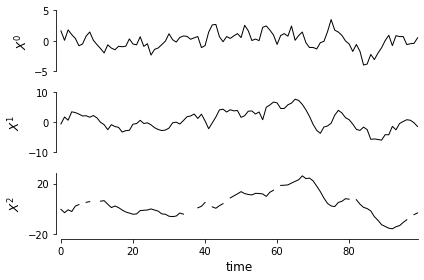

In [2]:
np.random.seed(1)
data = np.random.randn(100, 3)
for t in range(1, 100):
    data[t, 0] += 0.7*data[t-1, 0] 
    data[t, 1] += 0.8*data[t-1, 1] + 0.8*data[t-1,0]
    data[t, 2] += 0.8*data[t-1, 2] + 0.8*data[t-1,1]
# Randomly mark 10% of values as missing values in variable 2
data[np.random.permutation(100)[:10], 2] = 999.

# Initialize dataframe object, specify time axis and variable names
var_names = [r'$X^0$', r'$X^1$', r'$X^2$']
dataframe = pp.DataFrame(data, 
                         datatime = np.arange(len(data)), 
                         var_names=var_names,
                         missing_flag=999.)

tp.plot_timeseries(dataframe); plt.show()

In [3]:
pcmci_parcorr = PCMCI(dataframe=dataframe, cond_ind_test=ParCorr(verbosity=3), verbosity=4)
results = pcmci_parcorr.run_pcmci(tau_max=2, pc_alpha=0.2, alpha_level = 0.01)


# Initialize conditional independence test

Parameters:
independence test = par_corr
significance = analytic

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.2]
max_conds_dim = None
max_combinations = 1



## Variable $X^0$

Iterating through pc_alpha = [0.2]:

# pc_alpha = 0.2 (1/1):

Testing condition sets of dimension 0:

    Link ($X^0$ -1) --> $X^0$ (1/6):
        val =  0.688 | pval = 0.00000 
    Subset 0: () gives pval = 0.00000 / val =  0.688
    No conditions of dimension 0 left.

    Link ($X^0$ -2) --> $X^0$ (2/6):
        val =  0.449 | pval = 0.00000 
    Subset 0: () gives pval = 0.00000 / val =  0.449
    No conditions of dimension 0 left.

    Link ($X^1$ -1) --> $X^0$ (3/6):
        val =  0.355 | pval = 0.00039 
    Subset 0: () gives pval = 0.00039 / val =  0.355
    No conditions of dimension 0 left.

    Link ($X^1$ -2) --> $X^0$ (4/6):
        val =  0.248 | pval = 0.01470 
   

## Masking

Different from missing values, masking can be used to include or exclude samples depending on the situation. It is applied by means of the optional parameters ``mask`` and ``mask_type``:
- ``mask`` is an optional argument that can be passed when initializing a ``DataFrame`` object. It is a numpy array of the same shape as ``data`` and should contain the values ``0`` (or ``False``) or ``1`` (or ``True``). In this way each entry of ``data`` is associated with a ``0``or a ``1``, where ``0`` means that the entry is *not* supposed to be masked and ``1`` means it is supposed to be masked.
- ``mask_type`` is an optional argument that can be passed when initializing a conditional independence test object, for example ``ParCorr``. It is a string that can contain any combination of the characters ``x``, ``y`` and ``z``. If ``mask_type`` is left unspecified as ``None``, then the ``mask`` is not used. ``mask_type`` determines for which type of variables, as determined by their role in a conditional independence test, the mask is supposed to be active.

The details are as follows.

#### What masking does mechanically:

Consider testing whether $X = X^i_{t-\tau}$ is conditionally independent of $Y = X^j_t$ given $Z = \{X^k_{t-\tau_k}, X^l_{t-\tau_l}, \ldots\}$. This particular $Z$ is just for illustration, $Z$ could also be empty or have only one element. The individual samples thus are $s_n = (X^i_{n-\tau}, X^j_{n}, X^k_{n-\tau_k}, X^l_{n-\tau_l}, \ldots)$ with $2\cdot\tau_{\text{max}} \leq n \leq t$ (it is $2\cdot\tau_{\text{max}}$ and not $2\cdot\tau_{\text{max}}$ since the MCI test also conditions on the parents of the lagged variable). Then, the masking functionality excludes the sample $s_n$ from this test if at least one of these three conditions is true:
- The value $X^i_{n-\tau}$ is marked as masked by ``mask`` and the character ``x`` is in ``mask_type``.
- The value $X^j_{n}$ is marked as masked by ``mask`` and the character ``y`` is in ``mask_type``.
- The value $X^k_{n-\tau_k}$ or the value $X^l_{n-\tau_l}$ or $\ldots$ is marked as masked by ``mask`` and the character ``z`` is in ``mask_type``.

Intuitively, a sample $s_n$ is excluded from a conditional independence test if $i)$ one of its entries is a value that is marked as masked by ``mask`` **and** $ii)$ this entries corresponds to the $X$-type (or the $Y$-type or a $Z$-type) variable and ``mask_type`` indicates that the masking should be active for $X$-type (or $Y$-type or $Z$-type) variables.

#### Example 1:
Say we mark all values $X^i_s$ with $s$ **not** within the time range $[t_0, t_1]$ as masked and choose ``mask_type = y``. Then, only those samples for which the entry corresponding to the $Y$-type variable is taken from a time step within $[t_0, t_1]$ remain. In the above notation, only those $s_n$ with $t_0 \leq n \leq t_1$ remain. Note, however, that for some of these remaining samples the entries corresponding to the $X$-type or $Z$-type variables may be taken from outside the time window $[t_0, t_1]$. For example, if $X = X^i_{t-1}$ the sample $s_{t_0} = (X^i_{t_0-1}, X^j_{t_0}, X^k_{t_0-\tau_k}, X^l_{t_0-\tau_l}, \ldots)$ is retained although the value $X^i_{t_0-1}$ involves a time index that is outside the range $[t_0, t_1]$.

This is essentially the case that is described in [Kretschmer et al., 2016], with the difference that there the single interval $[t_0, t_1]$ is replaced by several intervals, each of which corresponds to December - February of one year.

[Kretschmer et al., 2016] Kretschmer, M., Coumou, D., Donges, J. F., and Runge, J. (01 Jun. 2016). Using causal effect networks to analyze different arctic drivers of midlatitude winter circulation. *Journal of Climate*, 29(11):4069 – 4081. [https://doi.org/10.1175/JCLI-D-15-0654.1](https://doi.org/10.1175/JCLI-D-15-0654.1).

#### Example 2:
With the same mask as in Example 1, choose ``mask_type = xy``. Then, all samples that were disregarded in Example 1 are also disregarded here. In addition, also the samples $s_n$ with $t_0 \leq n \leq t_0 + \tau - 1$ are disregarded. So if $\tau = 0$, no further sample is disregarded. If $\tau = 1$, the single sample $s_{t_0}$ is further disregarded. If $\tau = 2$, the two samples $s_{t_0}$ and $s_{t_0 + 1}$ are further disregarded. And so on. This indicates that including ``x`` and, yet more so, including ``z`` in ``mask_type`` strongly reduces the number of remaining samples if $\tau_{\text{max}}$ is chosen large.

To illustrate this, let us look at page 4073 last paragraph to page 4074 first paragraph in [Kretschmer et al., 2016] and see what would have happened if ``mask_type`` had been ``xy`` instead of ``y``. Here, $Y = \text{PoV}_t$ and $Z$ is empty. For $\tau = 1$, $X = \text{EA-snow}_{t-1}$. If ``mask_type`` was ``xy``, also $\text{EA-snow}$ would be limited to Dec - Feb. Therefore, each year would contribute only 2 instead of 3 samples (for monthly time resolution). These two samples are: $(\text{PoV in Feb}, \text{EA-snow in Jan})$, $(\text{PoV in Jan}, \text{EA-snow in Dec})$. For $\tau = 3$, $X = \text{EA-snow}_{t-3}$ and no samples would be left because $\text{PoV}$ in Feb would need to be paired with $\text{EA-snow}$ in Nov, which is out of the non-masked interval Dec - Feb. Similarly, $\text{PoV}$ in Jan (Dec) would need to be paired with $\text{EA-snow}$ in Oct (Sept), both of which are out of the non-masked interval.

#### What masking can be used for:
It allows to make use of background knowledge about causal stationarity, in particular it allows to specify a time range within which a certain causal mechanism is believed to be stationary. This is illustrated in the below figure: Running PCMCI on the whole time series (i.e., without masking) implicitly makes the assumption that the underlying causal structure remains the same over the entire time series, see the figure's upper part. A user may, however, have the background knowledge (or strong believe) that the causal structure may vary over time, for example between two regimes that alternate every 6 months as shown in the figure's lower part (the figure refers to these two regimes as *winter* and *summer* for illustration). In such a case masking allows to separately analyze the different regimes.

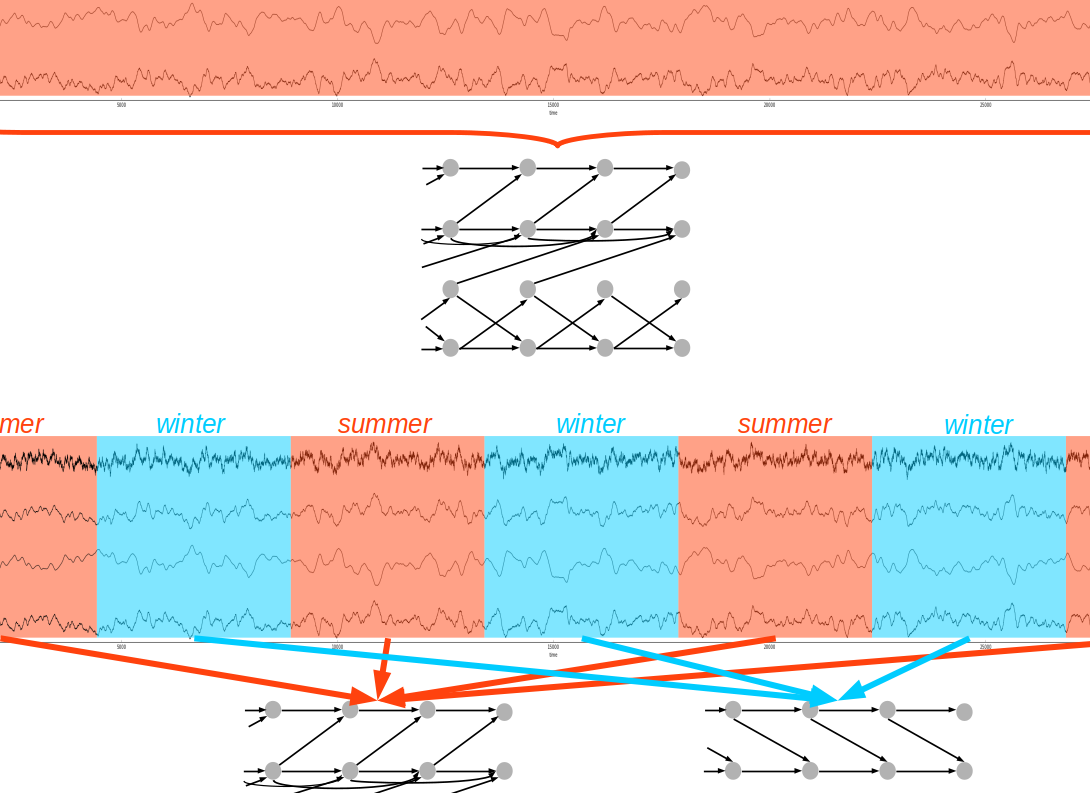

This example is similar to the application in [Kretschmer et al., 2016]. There, the use of the ``mask_type = y`` resulted in PCMCI only searching for causal drivers of target variables with the target variables restricted to Dec - Feb. The potential causal drivers, however, were allowed to be not only Dec - Feb. If in this example ``mask_type`` had been ``xy``, then also the potential causal drivers would have been restricted to Dec - Feb. If ``mask_type`` had been ``xyz``, in addition to the target variables and the potential causal drivers also the conditioning variables would have been restricted to Dec - Feb.

#### Example 3 (with code):
Below we generate data in which the underlying causal structure alternates between two regimes that are referred to as winter half year and summer half year. In particular, the two regimes differ in that one causal effect is of opposite sign in the two regimes.

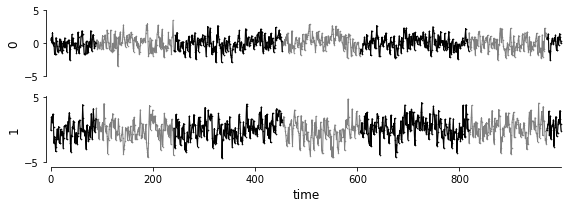

In [4]:
# Masking demo: We consider time series where the one part is generated by a different
# causal process than the other part. 
np.random.seed(42)
T = 1000
data = np.random.randn(T, 2)
data_mask = np.zeros(data.shape)
for t in range(1, T):
#     print t % 365
    if (t % 365) < 3*30 or (t % 365) > 8*30: 
        # Winter half year
        data[t, 0] +=  0.4*data[t-1, 0]
        data[t, 1] +=  0.3*data[t-1, 1] + 0.9*data[t-1, 0]
    else:
        # Summer half year
        data_mask[[t, t-1]] = True
        data[t, 0] +=  0.4*data[t-1, 0]
        data[t, 1] +=  0.3*data[t-1, 1] - 0.9*data[t-1, 0]

T, N = data.shape
# print data_mask[:100, 0]
dataframe = pp.DataFrame(data, mask=data_mask)
tp.plot_timeseries(dataframe, figsize=(8,3), use_mask=True, grey_masked_samples='data'); plt.show()


In [5]:
# Setup analysis
def run_and_plot(cond_ind_test, fig_ax, aspect=1):
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)
    results = pcmci.run_pcmci(tau_max=2, pc_alpha=0.2, alpha_level=0.01)
    tp.plot_graph(fig_ax = fig_ax,  val_matrix=results['val_matrix'],
                  graph=results['graph'], var_names=var_names,
                  node_aspect=aspect, node_size=0.02
    ); plt.show()

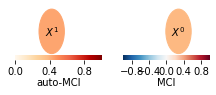

In [6]:
# Causal graph of whole year yields no link because effects average out
fig  = plt.figure(figsize=(3,1)); ax=fig.add_subplot(111)
run_and_plot(ParCorr(mask_type=None), (fig, ax), aspect=20.)

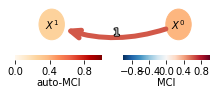

In [7]:
# Causal graph of winter half only gives positive link
fig  = plt.figure(figsize=(3,1)); ax=fig.add_subplot(111)
run_and_plot(ParCorr(mask_type='y'), (fig, ax), aspect=20.)

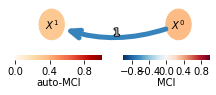

In [8]:
# Causal graph of summer half only gives negative link
fig  = plt.figure(figsize=(3,1)); ax=fig.add_subplot(111)
dataframe.mask[0] = (dataframe.mask[0] == False)
run_and_plot(ParCorr(mask_type='y'),  (fig, ax), aspect=20.)

Note, however, that the failure to detect the link on the whole sample occurs only for partial correlation because the positive and negative dependencies cancel out. Using CMIknn recovers the link (but gets a false positive for this realization):

In [9]:
# pcmci = PCMCI(dataframe=dataframe, cond_ind_test=CMIknn(mask_type=None))
# results = pcmci.run_pcmci(tau_max=2,pc_alpha=0.05, alpha_level=0.01)


In [10]:
# tp.plot_graph(val_matrix=results['val_matrix'],
#               node_aspect=5,
#               node_size=0.02,
#               figsize=(4,3),
#               graph=results['graph'], var_names=var_names)